# Bayesian inference on seizure propagation seen in sEEG data

__NB__ this is the old, original notebook from ~july 2015, _do not use_


In this notebook, we load & preprocess sEEG data, sensors & connectivity, then build a dynamical model linking the data, and use Hamiltonian Monte Carlo and variational inference techniques as implemented by the Stan software.

Contents

- [sEEG data](#sEEG)
- [Forward solution](##Forward-solution)
- [Connectivity](#Connectivity)
- [Seizure propagation model](#Seizure-propagation-model)
- [HMC](#HMC)

## Setup

Use inline figures and typical scientific functions

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


also, regular expressions, SciPy's signal processing toolbox, the Mako templating library & Python interface to Stan. Nibabel is used to handle some data. The `HTML` object lets us inline HTML in the notebook, e.g. displaying tables of data.

In [2]:
import re
from scipy import signal
from mako.template import Template
import pystan
import nibabel
from IPython.display import HTML

Finally, we set a few default options for figures

In [3]:
from matplotlib import rc
rc('lines', color='k')
rc('figure', figsize=(15, 5))
rc('image', cmap='binary', interpolation='nearest')
rc('patch', facecolor='k')
rc('axes', edgecolor='white')

## sEEG

Input data

- sEEG names, positions
- sEEG recording, artifacts rejected
- connectivity names, positions, weights
- fitting parameters

Steps

- sEEG are transformed to log power, corrected for baseline, linearly detrended
- summed power of log power, local peaks choose channels
- Windows spaced at 0.875 second intervals
- 2D reduction using dt=0.875 and tt to rescale time
- network reduced by selecting nodes with signifcant contribution to sEEG
- others considered constant


### Time series

A complex seizure was recorded via the sEEG implantation of this patient, at 512 Hz. We here load this dataset, parsing channel names to obtain the bipolar montage.

In [17]:
path = 'complex/'
contacts = []
with open(path + 'complex.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx))
    
bipnames = []
bipelec = []
bipidx = []
for i in range(len(contacts)-1):
    (ln, li), (rn, ri) = contacts[i:i+2]
    if ln != rn:
        continue
    bipnames.append('%s%d-%d' % (ln, li, ri))
    bipidx.append((i, i+1))
    bipelec.append(ln)
bip2mono = {k: v for k, v in zip(bipnames, bipidx)}

seeg = load(path + 'complex.npy')
seeg = seeg[:, :-200]
bip = array([seeg[i] - seeg[j] for i, j in bipidx])
print(seeg.shape, bip.shape)
fs = 512.0
t = r_[:seeg.shape[1]]/fs

(116, 417080) (105, 417080)


Next, we preprocess to select a frequency band of interest (2 - 15 Hz) & reduce the size of the data

In [18]:
b, a = signal.butter(3, 2*r_[2, 15]/fs, 'pass')
y = signal.lfilter(b, a, bip, axis=1)
y = y[:, ::15] # decim ~ 30 Hz
t = (r_[:seeg.shape[1]]/fs)[::15]
fs = 1/(t[1] - t[0])
print('effective fs after decimation is %0.2f Hz' % (fs, ))

effective fs after decimation is 34.13 Hz


Mean energy of the time derivative is used to pick 5 channels of interest

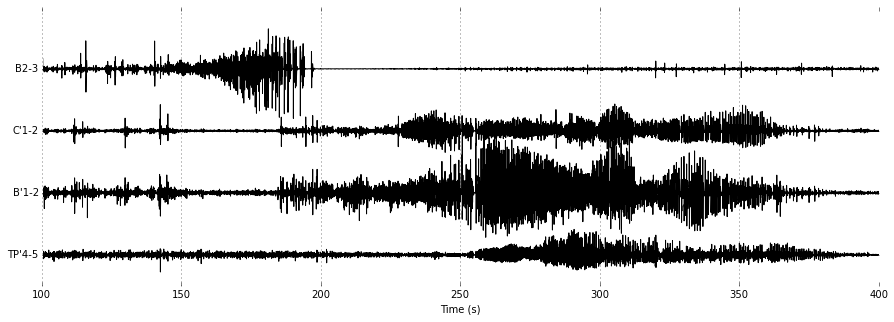

In [19]:
db2 = diff(bip, axis=1)**2
eni = argsort(mean(db2, axis=1))
eni = array(sort(eni[-4:]))

for i, yi in enumerate(y[eni]):
    plot(t, yi*2e-4 + i, 'k')
yticks(r_[:len(eni)], [bipnames[i] for i in eni]);
xlim([100, 400])
grid(True)
xlabel('Time (s)');

The seizure manifests between `t=100` & `t=400`, so we'll work only with that section

In [22]:
tm = c_[t>100, t<100.1].all(axis=1)
print('section contains %d samples' % (tm.sum(), ))

section contains 3 samples


### Forward solution

Our forward solution for sEEG is based on a dipole source model with dipoles at the centers of the regions used for connectivity estimation and the potential measured at contacts' positions. We first load the locations, then handle the contact locations

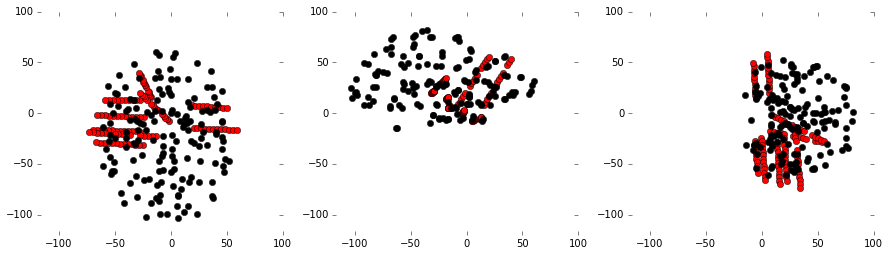

In [119]:
reg_xyz = loadtxt('centers.txt', usecols=(1,2,3))
reg_names = []
with open('centers.txt', 'r') as fd:
    for line in fd.readlines():
        reg_names.append(line.strip().split()[0])
seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T

seeg_labels = []
seeg_xyz = loadtxt('elecs_name.txt', usecols=(1,2,3))
with open('elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = array([seeg_xyz[i] for i in monopolar_chan_to_pos])

def _():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        subplot(1, 3, i + 1)
        plot(sa, sb, 'ro')
        plot(ra, rb, 'ko')
        axis([-120, 100, -120, 100])
        #xticks([]), yticks([])
figure(figsize=(15, 4))
_()

While quantitatively better approximations to the forward solution are available in packages like OpenMEEG, we start with Sarvas 1987 Eq 12 describing the potential due to a point dipole in homogeneous space $V(\textbf{r}) = \frac{1}{4 \pi \sigma} \textbf{Q} \cdot \frac{\textbf{r}-\textbf{r}_0}{|\textbf{r}-\textbf{r}_0|^3}$. 

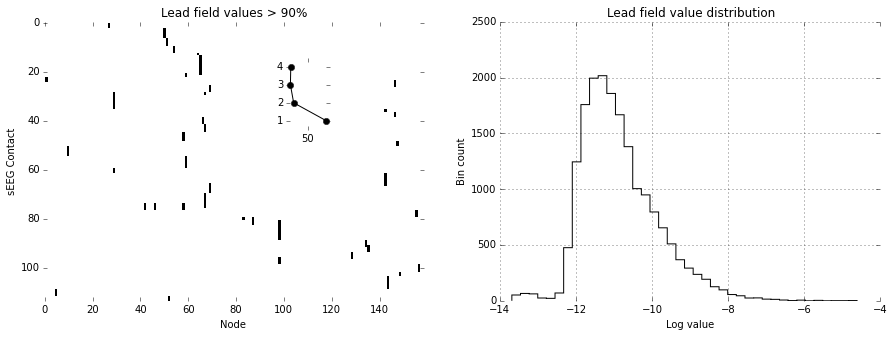

In [121]:
dr = reg_xyz - seeg_xyz[:, newaxis]
ndr = sqrt((dr**2).sum(axis=-1))
Vr = 1.0 / (4 * pi) / ndr**2
bVr = array([Vr[i] - Vr[j] for i, j in bipidx])

save('Vr.npy', Vr)

figure(figsize=(15, 5))
subplot(121)
nVr = Vr/Vr.max(axis=1)[:, newaxis] > 0.9
imshow(nVr, interpolation='nearest', aspect='auto')#, vmin=0.5, vmax=0.9)
title('Lead field values > 90%'), xlabel('Node'), ylabel('sEEG Contact')
a = axes([.35, .6, .04, .2])
n = bincount(nVr.sum(axis=1))
plot(n[1:], r_[1:len(n)], 'ko-')
yticks([1, 2, 3, 4]), xticks([50]), ylim([0.5, 4.5]), xlim([-10, 110])
subplot(122), hist(log(Vr).reshape((-1,)), 40, color='k', histtype='step'), grid(1);
title('Lead field value distribution'), xlabel('Log value'), ylabel('Bin count');

We will allow $\sigma$ to vary during inference, and thus drop it from the lead field calculation. Finally, for lack of high resolution in spatial geometry, the orientations of the sources are largely unknown and thus ignored. To make the correspondence between contacts and nodes clearer, the lead field is normalized by maximum per row and thresholded at 90%, and the inset shows a histogram of nodes (y-axis) exceeded the 90% threshold for contacts (x-axis).
 
For the current purposes, we asssume that few nodes in the whole brain network play a role in the seizure and thus contribute to the observed seizure. This allows us to reduce the number of electrodes and number of nodes in the network on which the inference is performed.

In [25]:
actnodes = []
for i in eni:
    ii = bipidx[i]
    ni = find(nVr[ii[0]:ii[1]+1].any(axis=0))
    print("%15s %45s" % (bipnames[i], ', '.join([reg_names[j] for j in ni])))
    actnodes += ni.tolist()
actnodes = unique(actnodes)

         TP'4-5                           ctx-lh-temporalpole
          B'1-2              ctx-lh-unknown, Left-Hippocampus
          C'1-2        Left-Thalamus-Proper, Left-Hippocampus
           B2-3                                Right-Amygdala


Here, for the four bipolar electrodes chosen, a total of five regions are implicated.

## Connectivity

Fiber tracking from grey-white matter boundaries performed on DTI, along with the chosen parcellation, generates a "weight" matrix out of fiber counts. To reduce symmetry breaking in the dynamics, this connectivity is normalized with respect to its afferents.

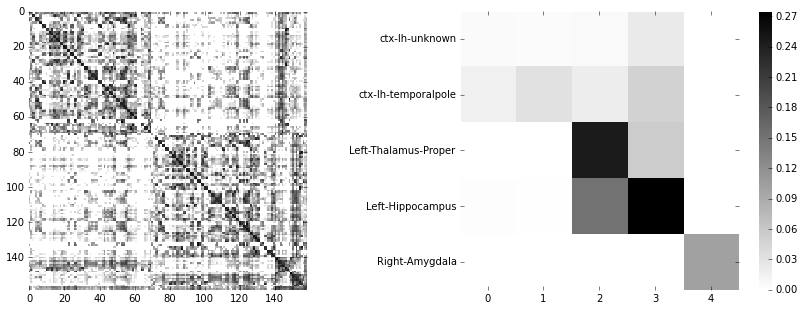

In [26]:
K_raw = loadtxt('weights.txt')
K = K_raw * 1.0 / K_raw.sum(axis=1)[:, newaxis]
subplot(121)
imshow(log(K+1e-5), interpolation='nearest')
subplot(122)
imshow(K[actnodes][:, actnodes])
yticks(r_[:len(actnodes)], [reg_names[i] for i in actnodes]);
colorbar();

The full connectivity shown on the left, and the reduced connectivity shown on the right.

## Seizure propagation model

Given the above preparations, we now need to encode the dynamic causal model for seizure propagation, including the neural mass dynamics, network connectivity & sEEG forward solution. The network dynamics follow Proix et al, Eq (2-6), 

$$
\begin{align}
  \dot{x}_{1, i} &= y_{1,i} - f_1(x_{1,i}, x_{2, i}, z_i) - z_i + I_{1, i} \\
  \dot{y}_{1, i} &= 1 - 5 (x_{1, i})^2 - y_{1, i} \\
  \tau_0 \dot{z}_i &= h(x_{1, i}) - z_i - k \sum_{j=1}^N K_{ij} (x_{1, j} - x{1, i}) \\
  \dot{x}_{2, i} &= -y_{2, i} + x_{2, i} - x_{2, i}^3 + I_{2, i} + 0.002 g_i - 0.3 (z_i - 3.5) \\
  \tau_2 \dot{y}_{2, i} &= -y_{2, i} + f_2(x_{1, i}, x_{2, i}) \\
  \dot{g}_i &= -\gamma g_i + x_{1, i}
\end{align}
$$

where a Euler-Maruyama scheme approximates the stochastic integral from time $t$ to $t + dt$, $dt=0.05$, 256 steps $\approx$ 1 second, thus in the inference model, a rescaling factor $w\approx12.8$ is introduced. Constants and auxiliary functions are taken from the paper verbatim.

The following describes the model, generates code for the Stan Bayesian inference system, based on a generic template.

In [72]:
# data
dims = 'nt ns nr'.split()
taus = 'fs dt'.split()
mats = {'sEEG': 'nt, ns', 'Gain': 'ns, nr', 'K': 'nr, nr'}

# parameters & model stuff
fns = [
    ('f1', 'x1 x2 z', 'if (x1<0) return x1^3-3*x1^2; else return (x2-0.6*(z-4)^2)*x1;'),
    ('f2', 'x1 x2', 'if (x2<-0.25) return 0.0; else return 6*(x2+0.25)*x1;'),
    ('h', 'x0 x1', 'return x0+(1.0/3.0)*(1.0+exp((-x1-0.5)/0.1));')
]

pars = {'q': 'vector<lower=1e-9>[6]', 'w': 'real<lower=1, upper=20>',
        'u': 'vector<lower=1e-9>[ns]', 'x0': 'vector<lower=2.8, upper=3>[nr]',
        'k': 'real<lower=0, upper=0.1>', 'cond': 'real<lower=1e-9>'}
svars = 'X1 Y1 Z X2 Y2 G'.split()
consts = {'tau0': 2857, 'tau2': 10, 'I1': 3.1, 'I2': 0.45, 'gamma': 0.01}
locs = 't0 tf t acc'.split()

# this is inserted verbatim in the template
ddt = """
print("[", x1, ",", y1, ",", z, ",", dx2, ",", dy2, ",", dg, "]");
for (i in 1:nr) {
    acc <- 0.0;
    for (j in 1:nr)
        acc <- acc + K[i, j] * (x1[j] - x1[i]);
    dx1[i] <- y1[i] - f1(x1[i], x2[i], z[i]) - z[i] + I1;
    dy1[i] <- 1.0 - 5.0 * x1[i]^2 - y1[i];
    dz[i] <- (h(x0[i], x1[i]) - z[i] - k * acc) / tau0;
    dx2[i] <- -y2[i] + x2[i] - x2[i]^3 + I2 + 0.002*g[i] - 0.3*(z[i] - 3.5);
    dy2[i] <- (-y2[i] + f2(x1[i], x2[i])) / tau2;
    dg[i] <- -gamma*(g[i] - 0.1*x1[i]);
}
"""

# predice sEEG signal from just x1 (no baseline shift seen in sEEG)
obs = "for (s in 1:nt) sEEG[s] ~ normal(Gain*X1[s]'/cond, u');"

# read template & render
with open('seizprop.stan.mako') as fd:
    model_code = Template(fd.read()).render(**locals())

# check that it compiles
try:
    pystan.stanc(model_code=model_code)
    with open('seizprop.stan', 'w') as fd:
        fd.write(model_code)
except Exception as e:
    print(e)
    print('\n'.join(['%03d\t%s' % (i+1, l) for i, l in enumerate(model_code.split('\n'))]))

## HMC

Run inference on the above model, given the contact & region selections 

In [73]:
pystan.stan_rdump({
    'nr': actnodes.size, 'nt': tm.sum(), 'ns': eni.size,
    'fs': fs, 'dt': 0.05/12.8,
    'sEEG': y[eni][:, tm].T, 'Gain': bVr[eni][:, actnodes], 'K': K[actnodes][:, actnodes]
}, 'temp.data.R')

In [74]:
!ls -lh *.data.R

-rw-r--r-- 1 mw mw 1.1K Aug  5 11:58 temp.data.R


In [75]:
!export here=$(pwd); cd ~/cmdstan/ && make $here/seizprop


--- Translating Stan model to C++ code ---
bin/stanc /home/mw/Dropbox/inversion/seizprop.stan --o=/home/mw/Dropbox/inversion/seizprop.hpp
Model name=seizprop_model
Input file=/home/mw/Dropbox/inversion/seizprop.stan
Output file=/home/mw/Dropbox/inversion/seizprop.hpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.2.4 -isystem stan/lib/stan_math/lib/boost_1.58.0 -Wall -pipe -DEIGEN_NO_DEBUG  -lpthread  -O3 -o /home/mw/Dropbox/inversion/seizprop src/cmdstan/main.cpp -include /home/mw/Dropbox/inversion/seizprop.hpp 


In [114]:
%%capture out
!./seizprop sample num_samples=50 num_warmup=50 data file=temp.data.R

In [115]:
ys = array([array(eval(l.strip())) for l in out.stdout.split('\n') if l.startswith('[')])

/home/mw/conda/envs/inversion/lib/python3.4/site-packages/matplotlib/lines.py:659: RuntimeWarning: invalid value encountered in subtract
  return np.amin(x[1:] - x[0:-1]) >= 0


(-2, 2)

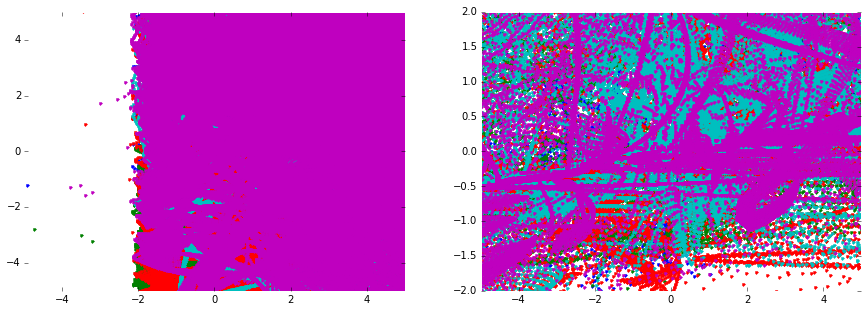

In [116]:
x1, y1, z, x2, y2, g = ys.transpose((1, 0, 2))
subplot(121)
plot(x1, y1, '.')
xlim([-5, 5])
ylim([-5, 5])
subplot(122)
plot(x2, y2, '.')
xlim([-5, 5])
ylim([-2, 2])

In [118]:
!cat *.csv

# stan_version_major = 2
# stan_version_minor = 7
# stan_version_patch = 0
# model = seizprop_model
# method = sample (Default)
#   sample
#     num_samples = 50
#     num_warmup = 50
#     save_warmup = 0 (Default)
#     thin = 1 (Default)
#     adapt
#       engaged = 1 (Default)
#       gamma = 0.050000000000000003 (Default)
#       delta = 0.80000000000000004 (Default)
#       kappa = 0.75 (Default)
#       t0 = 10 (Default)
#       init_buffer = 75 (Default)
#       term_buffer = 50 (Default)
#       window = 25 (Default)
#     algorithm = hmc (Default)
#       hmc
#         engine = nuts (Default)
#           nuts
#             max_depth = 10 (Default)
#         metric = diag_e (Default)
#         stepsize = 1 (Default)
#         stepsize_jitter = 0 (Default)
# id = 0 (Default)
# data
#   file = temp.data.R
# init = 2 (Default)
# random
#   seed = 76456824
# output
#   file = output.csv (Default)
#   diagnostic_file =  (Default)
#   refresh = 100 (Default)
lp__,accept_stat__,step

During debugging, we capture the output via the exception.

## TODO

- generative model for benchmarks
- cross validation on multiple datasets

In [15]:


























































# space intentionally left blank